# Image Captioning
### Text Generation from Image Data (using CNN and LSTM)

Image captioning is a captivating intersection of computer vision and natural language processing, aiming to bridge the gap between visual content and textual descriptions. In this project, we embark on a journey into the realm of image captioning using the Flickr8k dataset—a meticulously curated collection of 8000 images, each accompanied by five distinct descriptions.

Our approach to unraveling the rich tapestry of visual information involves the integration of Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks. CNNs are adept at extracting hierarchical features from images, allowing us to capture intricate details and patterns. Meanwhile, LSTM networks serve as potent tools for understanding and generating sequential data, making them well-suited for the textual aspect of image captioning.

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

By synergizing the strengths of CNNs and LSTMs, we aim to create a robust model that not only comprehends the visual nuances within images but also crafts meaningful and contextually relevant textual descriptions. This journey promises not just a technical exploration but an imaginative endeavor into the realms of artificial intelligence where pixels and words converge to tell a compelling visual story.

# Data exploration

Before delving into the intricacies of model development, it's crucial to embark on a journey of data exploration. The heart of our project, the Flickr8k dataset, beckons us to unravel its nuances and understand the visual and textual dimensions it encapsulates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from textwrap import wrap
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_path = '../input/flickr8k/Images'
data = pd.read_csv("../input/flickr8k/captions.txt")

In [3]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

The Flickr8k datase vomprise 8000 images, each accompanied by five distinct descriptions, this dataset serves as the canvas on which our model will paint visual narratives with linguistic flair.

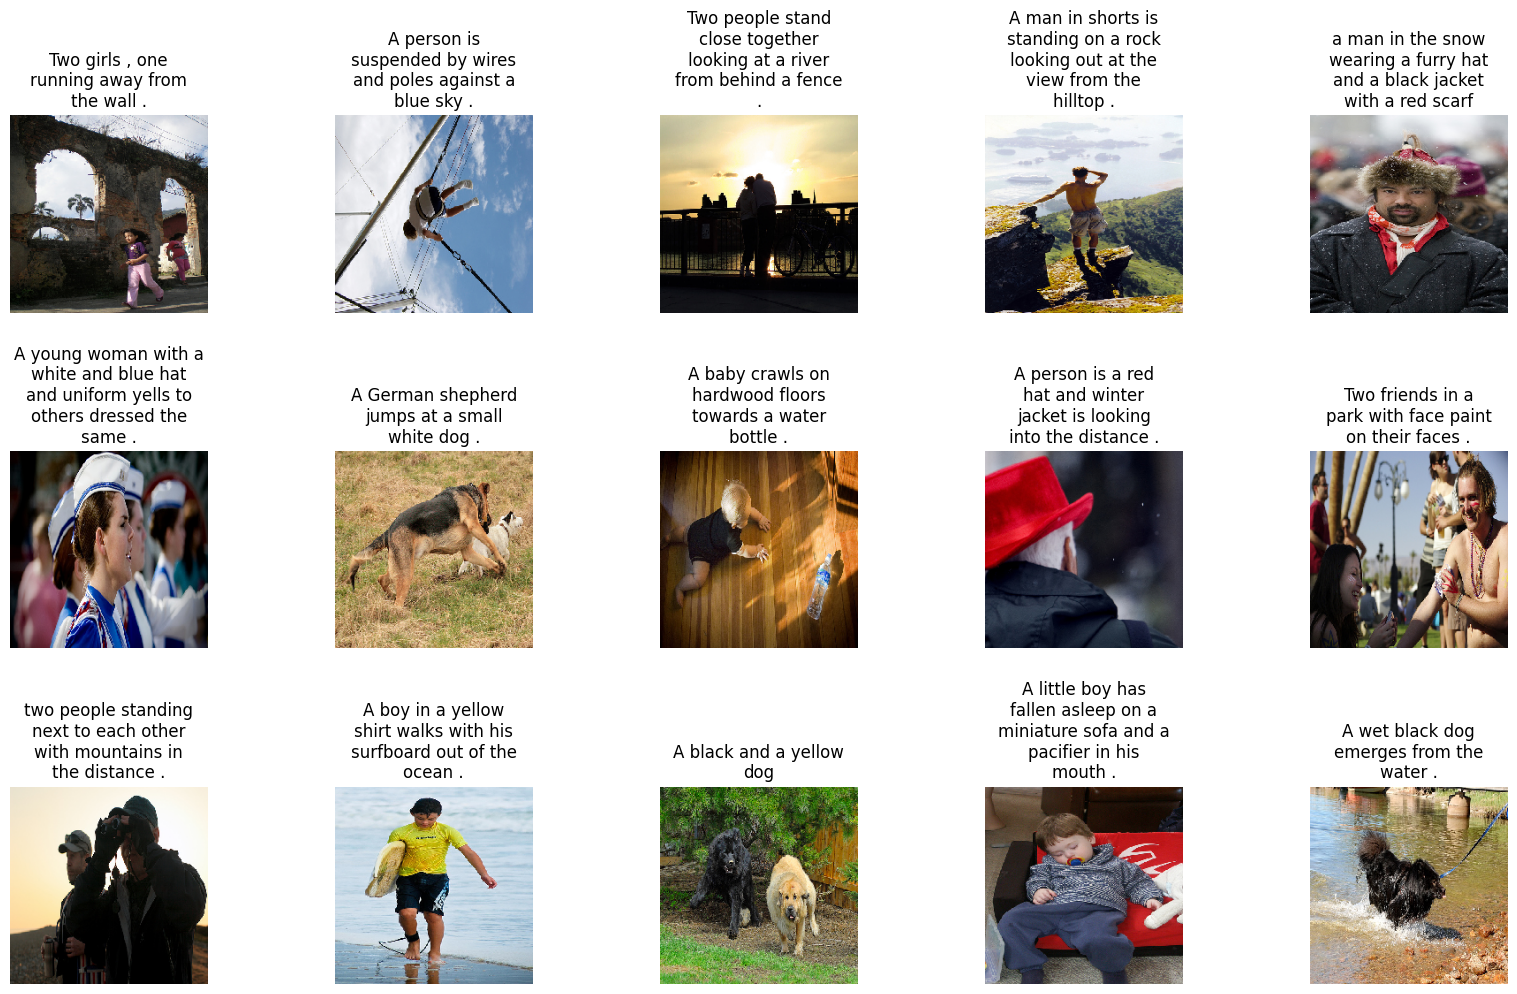

In [4]:
display_images(data.sample(15))

# Data preparation

With the Flickr8k dataset as our canvas, the next phase is data preparation which consists of shaping raw images and text into a format that harmonizes with our CNN-LSTM architecture.

## Text Preprocessing

As we embark on the textual facet of our image captioning odyssey, text preprocessing becomes the chisel that sculpts raw linguistic data into a form conducive to the nuanced understanding of our model.

In [5]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [6]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization and Encoded Representation

Begin by tokenizing the textual descriptions, breaking them down into individual units. Whether utilizing word-level or subword tokenization, this step lays the foundation for the model to comprehend the intricate dance of words within each caption.

This process involves assigning a unique numerical identifier to each token in the vocabulary. These encoded sequences transform the textual tapestry into a format compatible with the numerical intricacies of neural networks, readying it for the interpretive prowess of the Long Short-Term Memory (LSTM) network.

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# Image Feature Extraction

In [9]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tqdm import tqdm
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

DenseNet201, a deep convolutional neural network, stands as a stalwart in image feature extraction. Its architecture is characterized by dense connections between layers, allowing information to flow seamlessly across the network. This intricate connectivity promotes feature reuse, making it particularly effective in capturing hierarchical representations within images.

Deploy DenseNet201 as a feature extractor, removing its fully connected layers. The convolutional layers of this network act as adept feature detectors, identifying patterns, textures, and object hierarchies within images. Extract the output from these layers as high-dimensional feature vectors, encapsulating the visual essence of each image.

In [10]:
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [13:32<00:00,  9.96it/s]


# Data Generation

In [11]:
from tensorflow.keras.utils import Sequence

In [12]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# Model construction

With the stage set and the tools prepared, let's embark on the construction of our CNN-LSTM architecture—a symphony where visual and textual elements harmonize to breathe life into image captions.

In [13]:
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional , BatchNormalization,  Masking
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [15]:
# Image feature layers
input_image = Input(shape=(2048,))
fe1 = BatchNormalization()(input_image)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
input_caption = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
se1 = Masking(mask_value=0.0)(se1)  # Add a Masking layer
se2 = LSTM(256)(se1)

# Decoder Model
decoder1 = add([fe2, se2])
decoder1 = BatchNormalization()(decoder1)  # Adjust BatchNormalization placement
decoder2 = Dense(256, activation='relu', kernel_initializer='he_normal')(decoder1)
decoder2 = BatchNormalization()(decoder2)  # Adjust BatchNormalization placement
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Returning The Model
caption_model = Model(inputs=[input_image, input_caption], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

***Integration of Image Features:***
Begin by incorporating the extracted image feature vectors from DenseNet201 into the model. This serves as the visual backbone, capturing the hierarchical representations of objects, textures, and scenes within each image. These features become the canvas upon which the textual narrative will unfold.

**LSTM for Sequential Comprehension:**
Introduce the Long Short-Term Memory (LSTM) network to navigate the sequential nuances of language. The LSTM's ability to retain context over varying lengths of sequences aligns perfectly with the diverse lengths of our tokenized captions. This sequential comprehension becomes the key to articulating coherent and contextually rich textual descriptions.

**Embedding Layer for Text:**
Embed the tokenized and encoded textual representations into dense vectors using embedding layers. This transformation imbues each word with semantic depth, enhancing the model's linguistic finesse. The embedding layer serves as the bridge between raw textual data and the LSTM's sequential understanding.

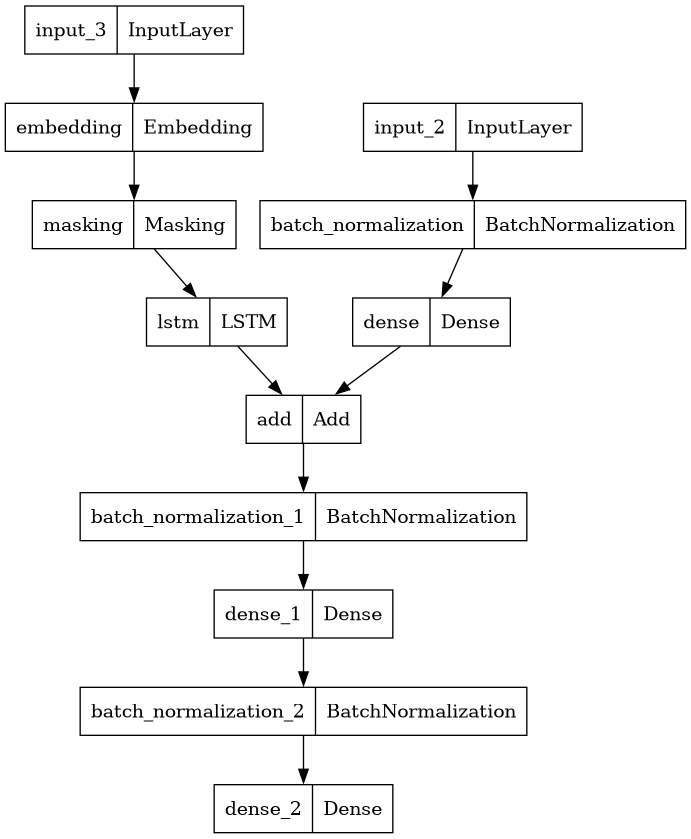

In [16]:
plot_model(caption_model)

# Model training

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [18]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [19]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [20]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - 263s 485ms/step - loss: 4.3540 - val_loss: 3.6226

Epoch 00001: val_loss improved from inf to 3.62264, saving model to model.h5
Epoch 2/50
537/537 [==============================] - 52s 96ms/step - loss: 3.5298 - val_loss: 3.3073

Epoch 00002: val_loss improved from 3.62264 to 3.30728, saving model to model.h5
Epoch 3/50
537/537 [==============================] - 52s 96ms/step - loss: 3.3080 - val_loss: 3.1904

Epoch 00003: val_loss improved from 3.30728 to 3.19043, saving model to model.h5
Epoch 4/50
537/537 [==============================] - 51s 95ms/step - loss: 3.1645 - val_loss: 3.1144

Epoch 00004: val_loss improved from 3.19043 to 3.11435, saving model to model.h5
Epoch 5/50
537/537 [==============================] - 51s 96ms/step - loss: 3.0592 - val_loss: 3.0830

Epoch 00005: val_loss improved from 3.11435 to 3.08299, saving model to model.h5
Epoch 6/50
537/537 [==============================] - 51s 95ms/step - loss: 2.9777

# Model Evaluation

## Categorical Crossentropy Loss

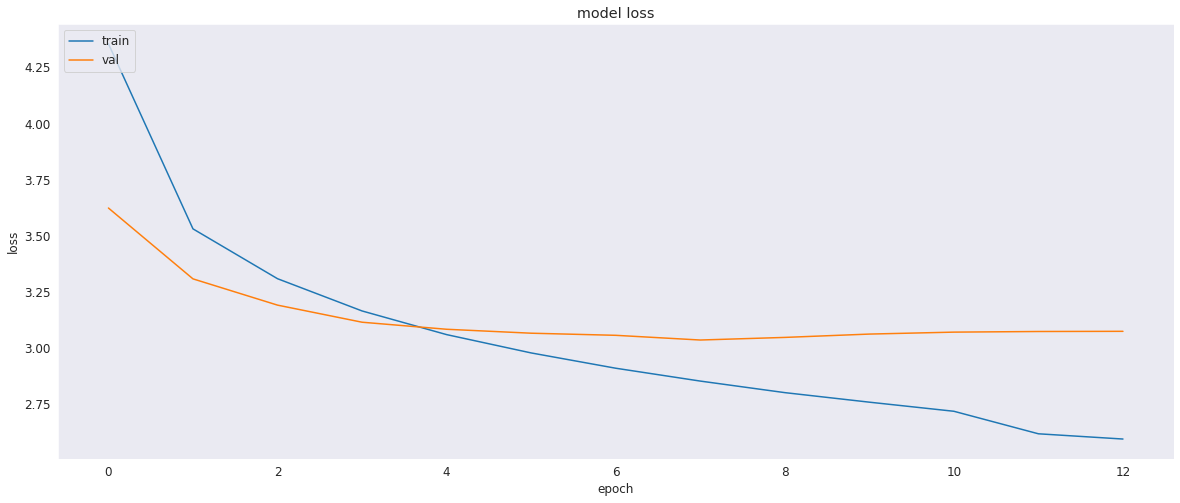

In [21]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## BLEU Loss

BLEU (Bilingual Evaluation Understudy) is a metric designed to evaluate the similarity between a generated caption and one or more reference captions. It operates by comparing n-grams (contiguous sequences of n items, typically words) present in the generated and reference captions. The resulting BLEU score ranges from 0 to 1, with 1 indicating perfect overlap.

In [29]:
def predict_captions(model,image_feature,tokenizer,max_len):
    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq'
    for i in range(max_len):
        seq = tok.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],maxlen=max_len)
        yhat = model.predict([image_feature,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat,tokenizer)
        if word is None:
            break;
        in_text+=" "+word;
        if word=='enseq':
            break;
    return in_text

In [30]:
%%time
# validate with test data:
actual, predicted = list(), list()

for key in tqdm(test[:20]):
    text = captions[key]
    actual_captions = [caption.split() for caption in text]
    y_pred = predict_captions(caption_model,features[key],tok,max_len)
    predicted_captions = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(predicted_captions)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 13.2 s, sys: 411 ms, total: 13.6 s
Wall time: 13.4 s


In [31]:
# calculate BLEU score:
from nltk.translate.bleu_score import corpus_bleu
print(f"BLEU-1: {corpus_bleu(actual,predicted,weights=(1.0,0,0,0))}")
print(f"BLEU-2: {corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0))}")

BLEU-1: 0.5616438356164384
BLEU-2: 0.3563774508171826


These scores provide valuable insights into the linguistic quality of your model's captions. Consider further analyzing and fine-tuning based on these metrics, and perhaps experimenting with different hyperparameters or model architectures to enhance performance.

## Génération de légendes

In [32]:
def get_captions(path):
    from PIL import Image
    img_id = path.split('/')[-1]
    img_id = img_id.split('.')[0]
    print(img_id)
    image = Image.open(path)
    data = captions[img_id]
    print('------------------Actual------------------')
    for caption in data:
        print(caption)
    y_pred = predict_captions(caption_model,features[img_id],tok,max_len)
    print('------------------Predicted------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

1016887272_03199f49c4
------------------Actual------------------
stseq collage of one person climbing cliff enseq
stseq group of people are rock climbing on rock climbing wall enseq
stseq group of people climbing rock while one man belays enseq
stseq seven climbers are ascending rock face whilst another man stands holding the rope enseq
stseq several climbers in row are climbing the rock while the man in red watches and holds the line enseq
------------------Predicted------------------
stseq man in red shirt and red shirt is climbing up rock while another man belays enseq


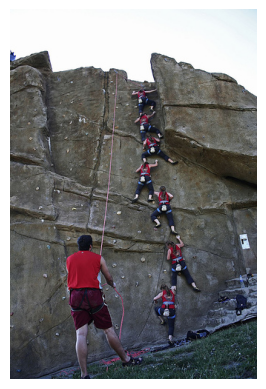

In [33]:
get_captions('/kaggle/input/flickr8k/Images/1016887272_03199f49c4.jpg')

1007320043_627395c3d8
------------------Actual------------------
stseq child playing on rope net enseq
stseq little girl climbing on red roping enseq
stseq little girl in pink climbs rope bridge at the park enseq
stseq small child grips onto the red ropes at the playground enseq
stseq the small child climbs on red ropes on playground enseq
------------------Predicted------------------
stseq the child in the red shirt climbs the ropes enseq


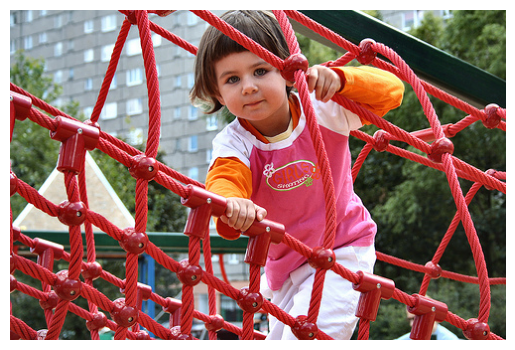

In [34]:
get_captions('/kaggle/input/flickr8k/Images/1007320043_627395c3d8.jpg')

**Good results!**

## Generating captions from Random images

In [35]:
def generate_captions_from_URL(path,CNN,main_model,tokenizer,max_len):
    img_path = path
    image_url = tf.keras.utils.get_file(origin=path )
    img = load_img(image_url, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    feature = CNN.predict(img, verbose=0)
    
    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],maxlen=max_len)
        yhat = model.predict([feature,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat,tokenizer)
        if word is None:
            break;
        in_text+=" "+word;
        if word=='enseq':
            break;
    from urllib.request import urlopen
    from PIL import Image
    plt.imshow(Image.open(urlopen(path)))
    plt.title(in_text)
    plt.axis('off')
    plt.show()

10839/10839 [==============================] - 0s 0us/step


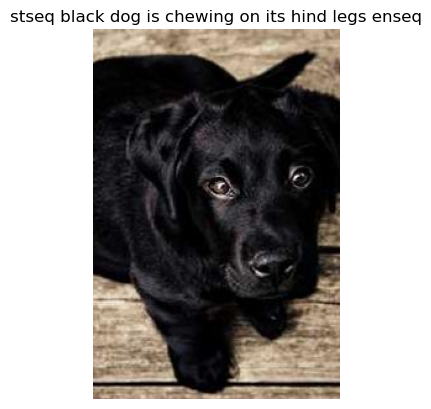

In [36]:
generate_captions_from_URL(path='https://picsum.photos/id/237/200/300',
                  CNN=img_model,main_model=model,tokenizer=tok,max_len=40)

2126411/2126411 [==============================] - 0s 0us/step


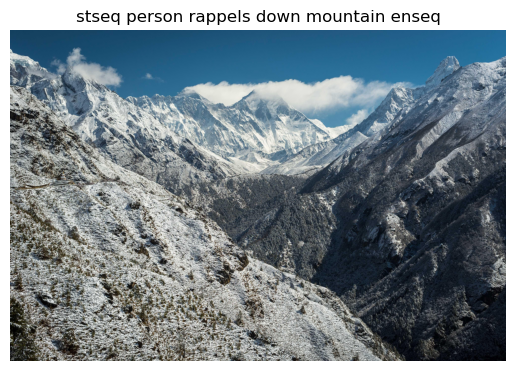

In [37]:
generate_captions_from_URL(path='https://fastly.picsum.photos/id/29/4000/2670.jpg?hmac=rCbRAl24FzrSzwlR5tL-Aqzyu5tX_PA95VJtnUXegGU',
                  CNN=img_model,main_model=model,tokenizer=tok,max_len=40)